<pre><font size=6>Spoken Digit Recognition</font></pre>

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install pytorch_lightning >> /dev/null
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/datasets/spokendigit/recordings.zip ./
!unzip recordings.zip >> /dev/null

Mounted at /content/drive


In [3]:
all_files = os.listdir("recordings")

In [5]:
path = ["./recordings/" + name for name in all_files]
label = [int(name.split("_")[0]) for name in all_files]
df_audio = pd.DataFrame({"path": path, "label": label})
df_audio

,path,label
0,./recordings/7_yweweler_38.wav,7
1,./recordings/2_jackson_16.wav,2
2,./recordings/4_theo_39.wav,4
3,./recordings/2_jackson_5.wav,2
4,./recordings/3_jackson_49.wav,3
...,...,...
1995,./recordings/3_nicolas_10.wav,3
1996,./recordings/6_jackson_0.wav,6
1997,./recordings/8_nicolas_9.wav,8
1998,./recordings/1_jackson_42.wav,1


In [6]:
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [8]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df_audio["path"], df_audio["label"], test_size=0.3, random_state=45,stratify = df_audio["label"]
)


<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [11]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [12]:
trian_wav = np.array(list(map(load_wav, X_train.values)), dtype=object)
X_train_processed = pd.DataFrame.from_dict(
    {"raw_data": trian_wav[:, 0], "duration": trian_wav[:, 1]}
)
X_train_processed.set_index(X_train.index, inplace=True)


test_wav = np.array(list(map(load_wav, X_test.values)), dtype=object)
X_test_processed = pd.DataFrame.from_dict(
    {"raw_data": test_wav[:, 0], "duration": test_wav[:, 1]}
)
X_test_processed.set_index(X_test.index, inplace=True)

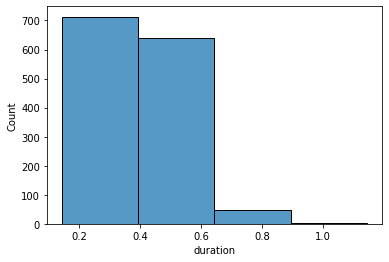

In [13]:
ax = sns.histplot(X_train_processed["duration"],binwidth=0.25)

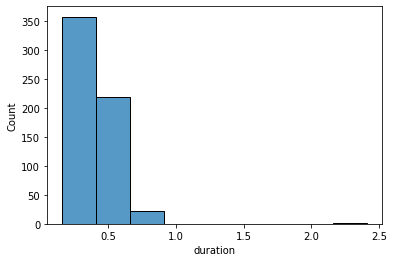

In [14]:
ax = sns.histplot(X_test_processed["duration"],binwidth=0.25)

In [15]:
for i in range(0,101,10):
    print("{} th percentile is {}".format(i, np.percentile(X_train_processed["duration"],i)))

0 th percentile is 0.1435374149659864
10 th percentile is 0.26312018140589566
20 th percentile is 0.30201360544217687
30 th percentile is 0.33503854875283445
40 th percentile is 0.36117913832199544
50 th percentile is 0.3920181405895692
60 th percentile is 0.418639455782313
70 th percentile is 0.44988662131519275
80 th percentile is 0.4877551020408163
90 th percentile is 0.5581768707482995
100 th percentile is 1.0351473922902494


In [16]:
for i in range(0,101,10):
    print("{} th percentile is {}".format(i, np.percentile(X_test_processed["duration"],i)))

0 th percentile is 0.16104308390022676
10 th percentile is 0.25524263038548756
20 th percentile is 0.29515646258503403
30 th percentile is 0.324453514739229
40 th percentile is 0.35365079365079366
50 th percentile is 0.38308390022675737
60 th percentile is 0.4120816326530612
70 th percentile is 0.44206802721088434
80 th percentile is 0.476671201814059
90 th percentile is 0.5372063492063492
100 th percentile is 2.282766439909297


<pre>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset. 

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640

Pad with Zero if length of sequence is less than 17640 else Truncate the number. 

Also create a masking vector for train and test. 

masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.
</pre>

In [18]:
max_length  = 17640

In [19]:
cols = max_length
train_rows = X_train_processed.shape[0]
X_train_pad_seq = np.zeros((train_rows,cols),dtype=float)
X_train_mask = np.ones((train_rows,cols),dtype=bool)

for i, data in enumerate(X_train_processed["raw_data"]):
    padding_length = max(0,max_length-len(data))
    X_train_pad_seq[i] = np.pad(data,(0,padding_length),mode='constant')[:max_length]
    X_train_mask[i][-padding_length:]=False


test_rows = X_test_processed.shape[0]
X_test_pad_seq = np.zeros((test_rows,cols),dtype=float)
X_test_mask = np.ones((test_rows,cols),dtype=bool)

for i, data in enumerate(X_test_processed["raw_data"]):
    padding_length = max(0,max_length-len(data))
    X_test_pad_seq[i] = np.pad(data,(0,padding_length),mode='constant')[:max_length]
    X_test_mask[i][-padding_length:]=False


### 1. Giving Raw data directly. 

In [21]:
class AudioData(Dataset):
    def __init__(self,data:pd.DataFrame,labels:pd.Series,transform=None):
        super().__init__()
        self.x = data["raw_data"].values
        self.y = labels.values

        if transform is not None:
            pass

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    
# https://www.codefull.net/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/
# https://pytorch-lightning.readthedocs.io/en/latest/sequences.html

class Padding:
    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        sequences = [torch.Tensor(x[0][:max_length][:,np.newaxis]) for x in sorted_batch]
        sequences_padded = pad_sequence(sequences, batch_first=True)
        lengths = torch.LongTensor([len(x) for x in sequences])
        labels = torch.LongTensor(list(map(lambda x: x[1], sorted_batch)))
        return sequences_padded, labels, lengths

In [22]:
train_data1 = AudioData(X_train_processed, y_train,transform=None)
test_data1 = AudioData(X_test_processed, y_test,transform=None)

train_size = len(train_data1)
val_size = int(0.02*train_size)
train_size -= val_size

val_data1, train_data1 = torch.utils.data.random_split(train_data1, [val_size, train_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data1,batch_size=32, shuffle=False, num_workers=2, collate_fn=Padding())
test_loader  = DataLoader(test_data1,batch_size=32, shuffle=False, num_workers=2, collate_fn=Padding())
val_loader   = DataLoader(val_data1,batch_size=32, shuffle=False, num_workers=2, collate_fn=Padding())

In [27]:
class LSTMSpokenDigit(pl.LightningModule):
    def __init__(self, seq_length=max_length, hidden_size=4, num_layers=4):
        super(LSTMSpokenDigit, self).__init__()
        self.f1 = pl.metrics.classification.F1(num_classes=10,average='micro')
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(1, self.hidden_size, self.num_layers, batch_first=True)
        self.dense = nn.Linear(self.num_layers*self.hidden_size, 10)
    
    def forward(self, x):
        _, (h,c) = self.lstm(x)
        x = self.flatten(torch.transpose(h, 0, 1))
        x = self.dense(x)
        return F.log_softmax(x,-1)
    
    def training_step(self, batch, batch_idx):
        x, y, lengths = batch
        x_pack = pack_padded_sequence(x,lengths.cpu(),batch_first=True)
        y_hat = self(x_pack)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def validation_step(self, batch, batch_idx):
        x, y, lengths = batch
        x_pack = pack_padded_sequence(x,lengths.cpu(),batch_first=True)
        y_hat = self(x_pack)
        loss = F.cross_entropy(y_hat, y)
        f1_score = self.f1(y_hat,y)
        self.log('val_loss', loss)
        self.log('f1_val', f1_score, prog_bar=True)
        #return {'val_loss': loss,'f1_val':f1_score}
    
    def test_step(self, batch, batch_idx):
        x, y, lengths = batch
        x_pack = pack_padded_sequence(x,lengths.cpu(),batch_first=True)
        y_hat = self(x_pack)
        loss = F.cross_entropy(y_hat, y)
        f1_score = self.f1(y_hat,y)
        self.log('test_loss', loss)
        self.log('f1_test', f1_score)
        #return {'test_loss': loss,'f1_test':f1_score}

model1 = LSTMSpokenDigit()
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=21)
trainer.fit(model1,train_loader,val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | f1      | F1      | 0     
1 | flatten | Flatten | 0     
2 | lstm    | LSTM    | 592   
3 | dense   | Linear  | 170   
------------------------------------
762       Trainable params
0         Non-trainable params
762       Total params


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [28]:
trainer.test(model1,test_loader)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'f1_test': tensor(0.1000, device='cuda:0'),
 'f1_val': tensor(0., device='cuda:0'),
 'test_loss': tensor(2.3027, device='cuda:0'),
 'val_loss': tensor(2.3070, device='cuda:0')}
--------------------------------------------------------------------------------


[{'f1_test': 0.10000000149011612,
  'f1_val': 0.0,
  'test_loss': 2.3026962280273438,
  'val_loss': 2.306990146636963}]

### 2. Converting into spectrogram and giving spectrogram data as input  
<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time
</pre>

In [29]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [30]:
X_train_spectrogram = np.array(list(map(convert_to_spectrogram, X_train_pad_seq)))
X_test_spectrogram = np.array(list(map(convert_to_spectrogram, X_test_pad_seq)))

In [32]:
class AudioSpectrogram(Dataset):
    def __init__(self,data:np.array,labels:pd.Series,transform=None):
        super().__init__()
        self.x = data
        self.y = labels.values

        if transform is not None:
            pass

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

train_data2 = AudioSpectrogram(X_train_spectrogram, y_train, transform=None)
test_data2 = AudioSpectrogram(X_test_spectrogram, y_test, transform=None)

train_size = len(train_data2)
val_size = int(0.08*train_size)
train_size -= val_size

val_data2, train_data2 = torch.utils.data.random_split(train_data2, [val_size, train_size], generator=torch.Generator().manual_seed(42))

train_loader2 = DataLoader(train_data2,batch_size=32, shuffle=True)
test_loader2  = DataLoader(test_data2,batch_size=32, shuffle=False)
val_loader2   = DataLoader(val_data2,batch_size=32, shuffle=False)

In [37]:
class LSTMSpectrogram(pl.LightningModule):
    def __init__(self, n_features=35, seq_length=64, hidden_size=35, num_layers=4):
        super(LSTMSpectrogram, self).__init__()
        self.f1 = pl.metrics.classification.F1(num_classes=10,average='micro')
        self.n_features = n_features
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(self.n_features, self.hidden_size, self.num_layers, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.dense = nn.Linear(self.seq_length, 10)
    
    def forward(self, x):
        x, _ = self.lstm(x.float())
        x = torch.mean(x, 2, True)
        x  = self.flatten(x)
        x = self.dropout(x)
        x = self.dense(x)
        return F.log_softmax(x, -1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=1e-3)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        f1_score = self.f1(y_hat,y)
        self.log('val_loss', loss)
        self.log('f1_val', f1_score, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        f1_score = self.f1(y_hat,y)
        self.log('test_loss', loss)
        self.log('f1_test', f1_score)

model2 = LSTMSpectrogram()
trainer2 = pl.Trainer(gpus=0, progress_bar_refresh_rate=25,max_epochs=150)
trainer2.fit(model2,train_loader2,val_dataloaders=val_loader2)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name    | Type    | Params
------------------------------------
0 | f1      | F1      | 0     
1 | flatten | Flatten | 0     
2 | lstm    | LSTM    | 40.3 K
3 | dropout | Dropout | 0     
4 | dense   | Linear  | 650   
------------------------------------
41.0 K    Trainable params
0         Non-trainable params
41.0 K    Total params


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [38]:
trainer2.test(model2,test_dataloaders=test_loader2)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'f1_test': tensor(0.8900),
 'f1_val': tensor(0.8304),
 'test_loss': tensor(0.4158),
 'val_loss': tensor(0.4210)}
--------------------------------------------------------------------------------


[{'f1_test': 0.8899999856948853,
  'f1_val': 0.8303571343421936,
  'test_loss': 0.4157596230506897,
  'val_loss': 0.42100265622138977}]

### 3. data augmentation  
<pre>

We apply two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

In [39]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [40]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [41]:
len(aug_temp)

9

In [42]:
X_train_aug = np.array(list(itertools.chain.from_iterable(map(generate_augmented_data, X_train))))
y_train_aug = np.array(list(itertools.chain.from_iterable([[label]*9 for label in y_train])))

train_aug_seq_len = np.array(list(map(len, X_train_aug)))
assert(len(X_train_aug)==len(y_train_aug)==len(train_aug_seq_len))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [43]:
X_test_aug = np.array(list(itertools.chain.from_iterable(map(generate_augmented_data, X_test))))
y_test_aug = np.array(list(itertools.chain.from_iterable([[label]*9 for label in y_test])))

test_aug_seq_len = np.array(list(map(len, X_test_aug)))
assert(len(X_test_aug)==len(y_test_aug)==len(test_aug_seq_len))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


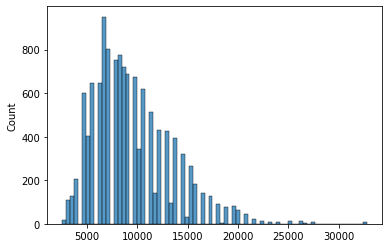

In [44]:
ax = sns.histplot(train_aug_seq_len)

In [45]:
np.percentile(train_aug_seq_len, 99)

20992.0

In [46]:
max_length = 21000

In [50]:
# model 3

max_length = 21000

class AudioDataAug(Dataset):
    def __init__(self,data:np.array,labels:np.array,transform=None):
        super().__init__()
        self.x = data
        self.y = labels

        if transform is not None:
            pass

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

train_data3 = AudioDataAug(X_train_aug, y_train_aug,transform=None)
test_data3 = AudioDataAug(X_test_aug, y_test_aug,transform=None)

train_size = len(train_data3)
val_size = int(0.02*train_size)
train_size -= val_size

val_data3, train_data3 = torch.utils.data.random_split(train_data3, [val_size, train_size], generator=torch.Generator().manual_seed(42))

train_loader3 = DataLoader(train_data3,batch_size=128, shuffle=False, num_workers=2, collate_fn=Padding())
test_loader3 = DataLoader(test_data3,batch_size=128, shuffle=False, num_workers=2, collate_fn=Padding())
val_loader3 = DataLoader(val_data3,batch_size=32, shuffle=False, num_workers=2, collate_fn=Padding())

model3 = LSTMSpokenDigit(max_length)
trainer3 = pl.Trainer(gpus=1, progress_bar_refresh_rate=21)
trainer3.fit(model3, train_loader3, val_dataloaders=val_loader3)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | f1      | F1      | 0     
1 | flatten | Flatten | 0     
2 | lstm    | LSTM    | 592   
3 | dense   | Linear  | 170   
------------------------------------
762       Trainable params
0         Non-trainable params
762       Total params


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [51]:
trainer3.test(model3, test_dataloaders=test_loader3)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'f1_test': tensor(0.1000, device='cuda:0'),
 'f1_val': tensor(0.0833, device='cuda:0'),
 'test_loss': tensor(2.3028, device='cuda:0'),
 'val_loss': tensor(2.3035, device='cuda:0')}
--------------------------------------------------------------------------------


[{'f1_test': 0.10000000149011612,
  'f1_val': 0.0833333358168602,
  'test_loss': 2.3027541637420654,
  'val_loss': 2.3034818172454834}]

In [52]:
# model 4
max_length = 21000

cols = max_length
train_rows = X_train_aug.shape[0]
X_train_aug_pad_seq = np.zeros((train_rows,cols),dtype=float)
X_train_mask = np.ones((train_rows,cols),dtype=bool)

for i, data in enumerate(X_train_aug):
    padding_length = max(0,max_length-len(data))
    X_train_aug_pad_seq[i] = np.pad(data,(0,padding_length),mode='constant')[:max_length]
    X_train_mask[i][-padding_length:]=False


test_rows = X_test_aug.shape[0]
X_test_aug_pad_seq = np.zeros((test_rows,cols),dtype=float)
X_test_mask = np.ones((test_rows,cols),dtype=bool)

for i, data in enumerate(X_test_aug):
    padding_length = max(0,max_length-len(data))
    X_test_aug_pad_seq[i] = np.pad(data,(0,padding_length),mode='constant')[:max_length]
    X_test_mask[i][-padding_length:]=False




X_train_aug_spectrogram = np.array(list(map(convert_to_spectrogram, X_train_aug_pad_seq)))
X_test_aug_spectrogram = np.array(list(map(convert_to_spectrogram, X_test_aug_pad_seq)))

class AudioSpectrogram(Dataset):
    def __init__(self,data:np.array,labels:np.array,transform=None):
        super().__init__()
        self.x = data
        self.y = labels

        if transform is not None:
            pass

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

train_data4 = AudioSpectrogram(X_train_aug_spectrogram, y_train_aug, transform=None)
test_data4 = AudioSpectrogram(X_test_aug_spectrogram, y_test_aug, transform=None)

train_size = len(train_data4)
val_size = int(0.08*train_size)
train_size -= val_size

val_data4, train_data4 = torch.utils.data.random_split(train_data4, [val_size, train_size], generator=torch.Generator().manual_seed(42))

train_loader4 = DataLoader(train_data4,batch_size=32, shuffle=True)
test_loader4  = DataLoader(test_data4,batch_size=32, shuffle=False)
val_loader4   = DataLoader(val_data4,batch_size=32, shuffle=False)

In [55]:
model4 = LSTMSpectrogram(n_features=42, seq_length=64, hidden_size=42)
trainer4 = pl.Trainer(gpus=0, progress_bar_refresh_rate=25,max_epochs=150)
trainer4.fit(model4,train_loader4,val_dataloaders=val_loader4)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name    | Type    | Params
------------------------------------
0 | f1      | F1      | 0     
1 | flatten | Flatten | 0     
2 | lstm    | LSTM    | 57.8 K
3 | dropout | Dropout | 0     
4 | dense   | Linear  | 650   
------------------------------------
58.4 K    Trainable params
0         Non-trainable params
58.4 K    Total params


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [57]:
trainer4.test(model4, test_dataloaders=test_loader4)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'f1_test': tensor(0.9337),
 'f1_val': tensor(0.9375),
 'test_loss': tensor(0.1955),
 'val_loss': tensor(0.1836)}
--------------------------------------------------------------------------------


[{'f1_test': 0.9337037205696106,
  'f1_val': 0.9375,
  'test_loss': 0.19548103213310242,
  'val_loss': 0.18357063829898834}]